# ReceiptDetection
<img src="https://www.domtar.com/wp-content/uploads/2024/03/Receipts-Papers.png" width="1000" height="500">


YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!curl -L -o vietnamese-receipts-mc-ocr-2021.zip\
  https://www.kaggle.com/api/v1/datasets/download/domixi1989/vietnamese-receipts-mc-ocr-2021?datasetVersionNumber=2

!unzip vietnamese-receipts-mc-ocr-2021.zip -d receipts-mc-ocr

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  337M  100  337M    0     0   103M      0  0:00:03  0:00:03 --:--:--  130M
Archive:  vietnamese-receipts-mc-ocr-2021.zip
  inflating: receipts-mc-ocr/mcocr_train_df.csv  
  inflating: receipts-mc-ocr/mcocr_val_sample_df.csv  
  inflating: receipts-mc-ocr/results.csv  
  inflating: receipts-mc-ocr/train_images/train_images/mcocr_public_145013aagqw.jpg  
  inflating: receipts-mc-ocr/train_images/train_images/mcocr_public_145013aaprl.jpg  
  inflating: receipts-mc-ocr/train_images/train_images/mcocr_public_145013acjke.jpg  
  inflating: receipts-mc-ocr/train_images/train_images/mcocr_public_145013adyee.jpg  
  inflating: receipts-mc-ocr/train_images/train_images/mcocr_public_145013aedmq.jpg  
  inflating: receipts-mc-ocr/train_images/train_images/mcocr

In [ ]:
# SELLER|||ADDRESS|||TIMESTAMP|||TOTAL_COST
# 15 ||| 16 ||| 17 ||| 18
# 0 ||| 1 ||| 2 ||| 3

In [ ]:
map_id = {15:0, 16:1, 17:2, 18:3}

In [ ]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil

# Define paths
src_image_dir = '/content/receipts-mc-ocr/train_images/train_images'
src_label_dir = '/content/receipts-mc-ocr/train_images/train_labels'
train_image_dir = '/content/dataset/train/images'
val_image_dir = '/content/dataset/val/images'
train_label_dir = '/content/dataset/train/labels'
val_label_dir = '/content/dataset/val/labels'

# Create train and val directories
os.makedirs(src_image_dir, exist_ok=True)
os.makedirs(src_label_dir, exist_ok=True)
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

In [ ]:
df = pd.read_csv('/content/receipts-mc-ocr/mcocr_train_df.csv')

for idx in range(len(df)):
    sample = df.iloc[idx]
    path = os.path.join(src_image_dir, sample["img_id"])

    with open(os.path.join(src_label_dir, f"{sample['img_id'][:-4]}.txt"), "w") as f:
        for detect in eval(sample["anno_polygons"]):
            label = map_id.get(detect["category_id"])
            width = detect["width"]
            height = detect["height"]

            normalized_polygon = []
            polygon = detect["segmentation"][0]
            for i in range(0, len(polygon), 2):
                x = polygon[i] / width
                y = polygon[i + 1] / height
                normalized_polygon.extend([f"{x:.6f}", f"{y:.6f}"])

            segmentation = " ".join(normalized_polygon)
            # Write to file in YOLO format
            f.write(f"{label} {segmentation}\n")

In [ ]:
# Get list of all files in the source directory
image_paths = os.listdir(src_image_dir)
label_paths = os.listdir(src_label_dir)
len_paths = len(image_paths)

# Split into train and validation sets
train_image_paths = image_paths[:int(len_paths * 0.9)]
val_image_paths = image_paths[int(len_paths * 0.9):]

# Move files to the train directory
for file_name in train_image_paths:
    shutil.move(os.path.join(src_image_dir, file_name), train_image_dir)
    shutil.move(os.path.join(src_label_dir, f"{file_name[:-4]}.txt"), train_label_dir)

# Move files to the val directory
for file_name in val_image_paths:
    shutil.move(os.path.join(src_image_dir, file_name), val_image_dir)
    shutil.move(os.path.join(src_label_dir, f"{file_name[:-4]}.txt"), val_label_dir)

print(f"Moved {len(train_image_paths)} files to {train_image_dir}")
print(f"Moved {len(train_image_paths)} files to {train_label_dir}")
print(f"Moved {len(val_image_paths)} files to {val_image_dir}")
print(f"Moved {len(val_image_paths)} files to {val_label_dir}")

Moved 1039 files to /content/dataset/train/images
Moved 1039 files to /content/dataset/train/labels
Moved 116 files to /content/dataset/val/images
Moved 116 files to /content/dataset/val/labels


In [ ]:
data_yaml = dict(
    train=train_image_dir,  # Path to training images
    val=val_image_dir,      # Path to validation images
    nc=4,                   # Number of classes
    names=['SELLER', 'ADDRESS', 'TIMESTAMP', 'TOTAL_COST']  # List of class names
)

In [ ]:
import yaml

with open('data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

In [ ]:
!nvidia-smi

Sun Jan  5 08:57:16 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.4/112.6 GB disk)


## Custom Training

In [ ]:
!yolo task=segment mode=train model=yolo11n-seg.pt data={HOME}/data.yaml epochs=40 imgsz=640 plots=True

100% 5.90M/5.90M [00:00<00:00, 107MB/s]
New https://pypi.org/project/ultralytics/8.3.57 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=/content/data.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False,

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [ ]:
!ls {HOME}/runs/segment/train/

args.yaml					   MaskF1_curve.png	train_batch1.jpg
BoxF1_curve.png					   MaskP_curve.png	train_batch2.jpg
BoxP_curve.png					   MaskPR_curve.png	val_batch0_labels.jpg
BoxPR_curve.png					   MaskR_curve.png	val_batch0_pred.jpg
BoxR_curve.png					   results.csv		val_batch1_labels.jpg
confusion_matrix_normalized.png			   results.png		val_batch1_pred.jpg
confusion_matrix.png				   train_batch0.jpg	val_batch2_labels.jpg
events.out.tfevents.1736067456.0337b310fda3.741.0  train_batch1950.jpg	val_batch2_pred.jpg
labels_correlogram.jpg				   train_batch1951.jpg	weights
labels.jpg					   train_batch1952.jpg


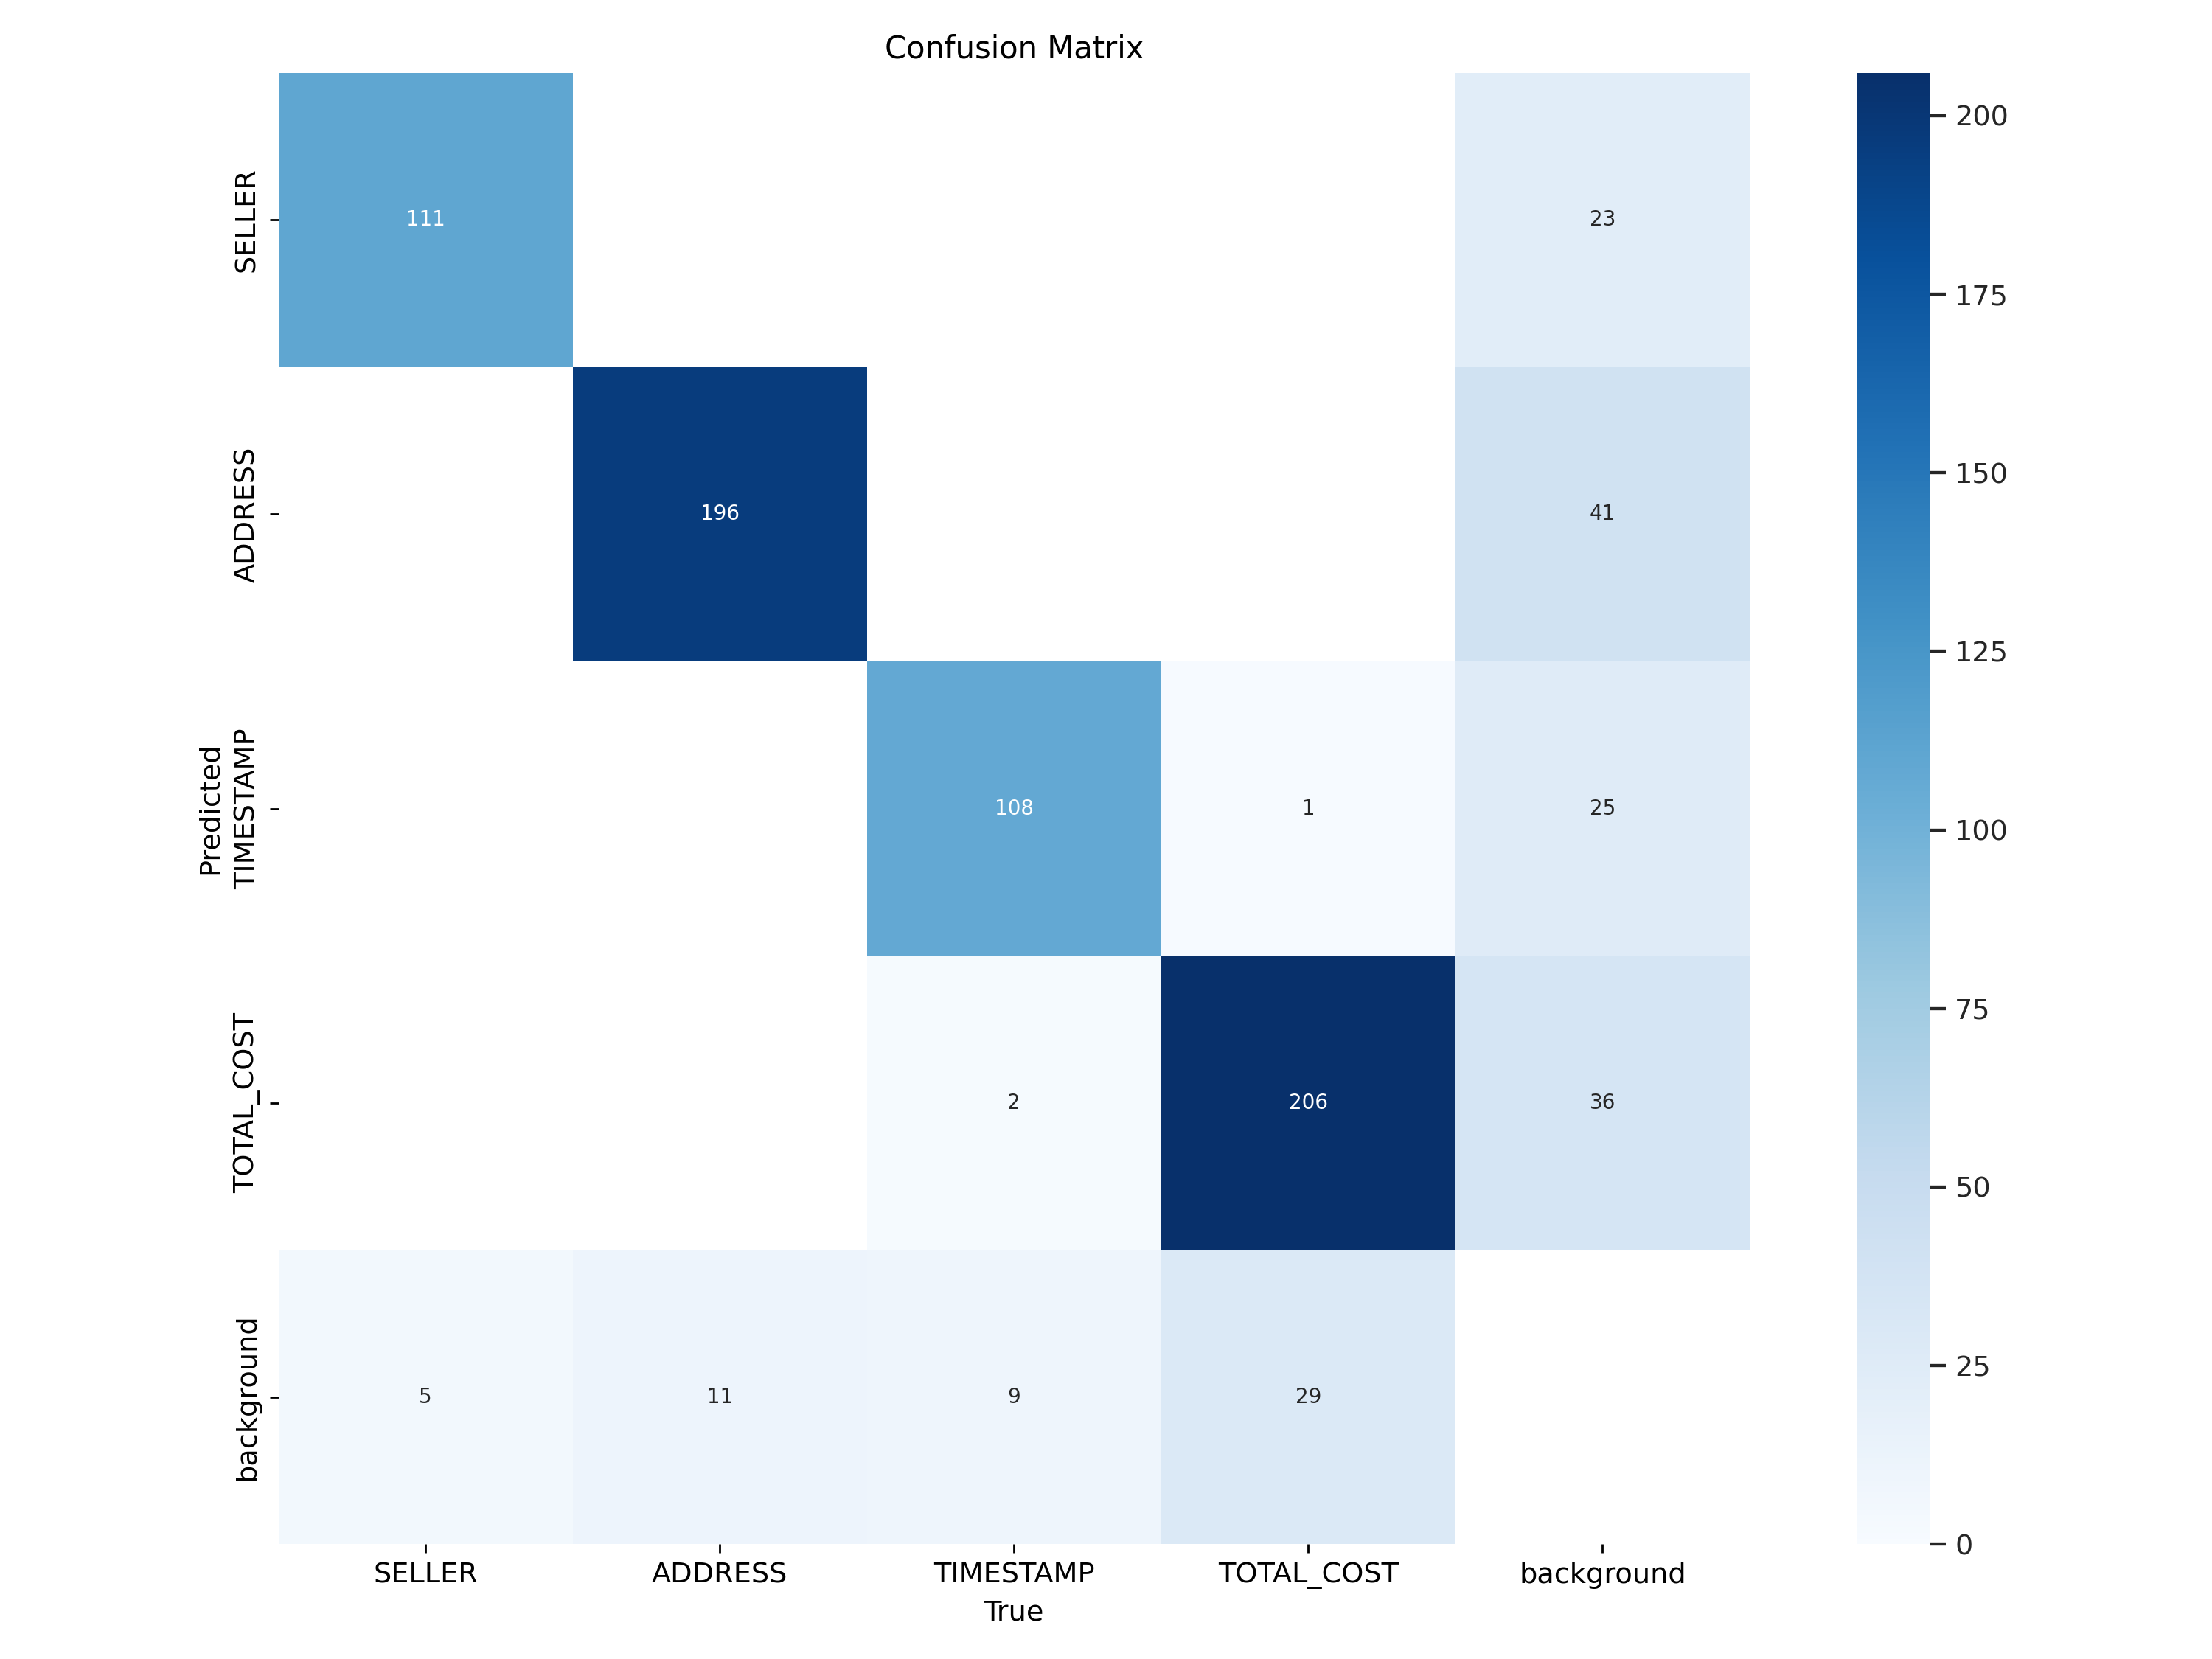

In [ ]:
from IPython.display import Image as IPyImage
ssssss
IPyImage(filename=f'{HOME}/runs/segment/train/confusion_matrix.png', width=600)

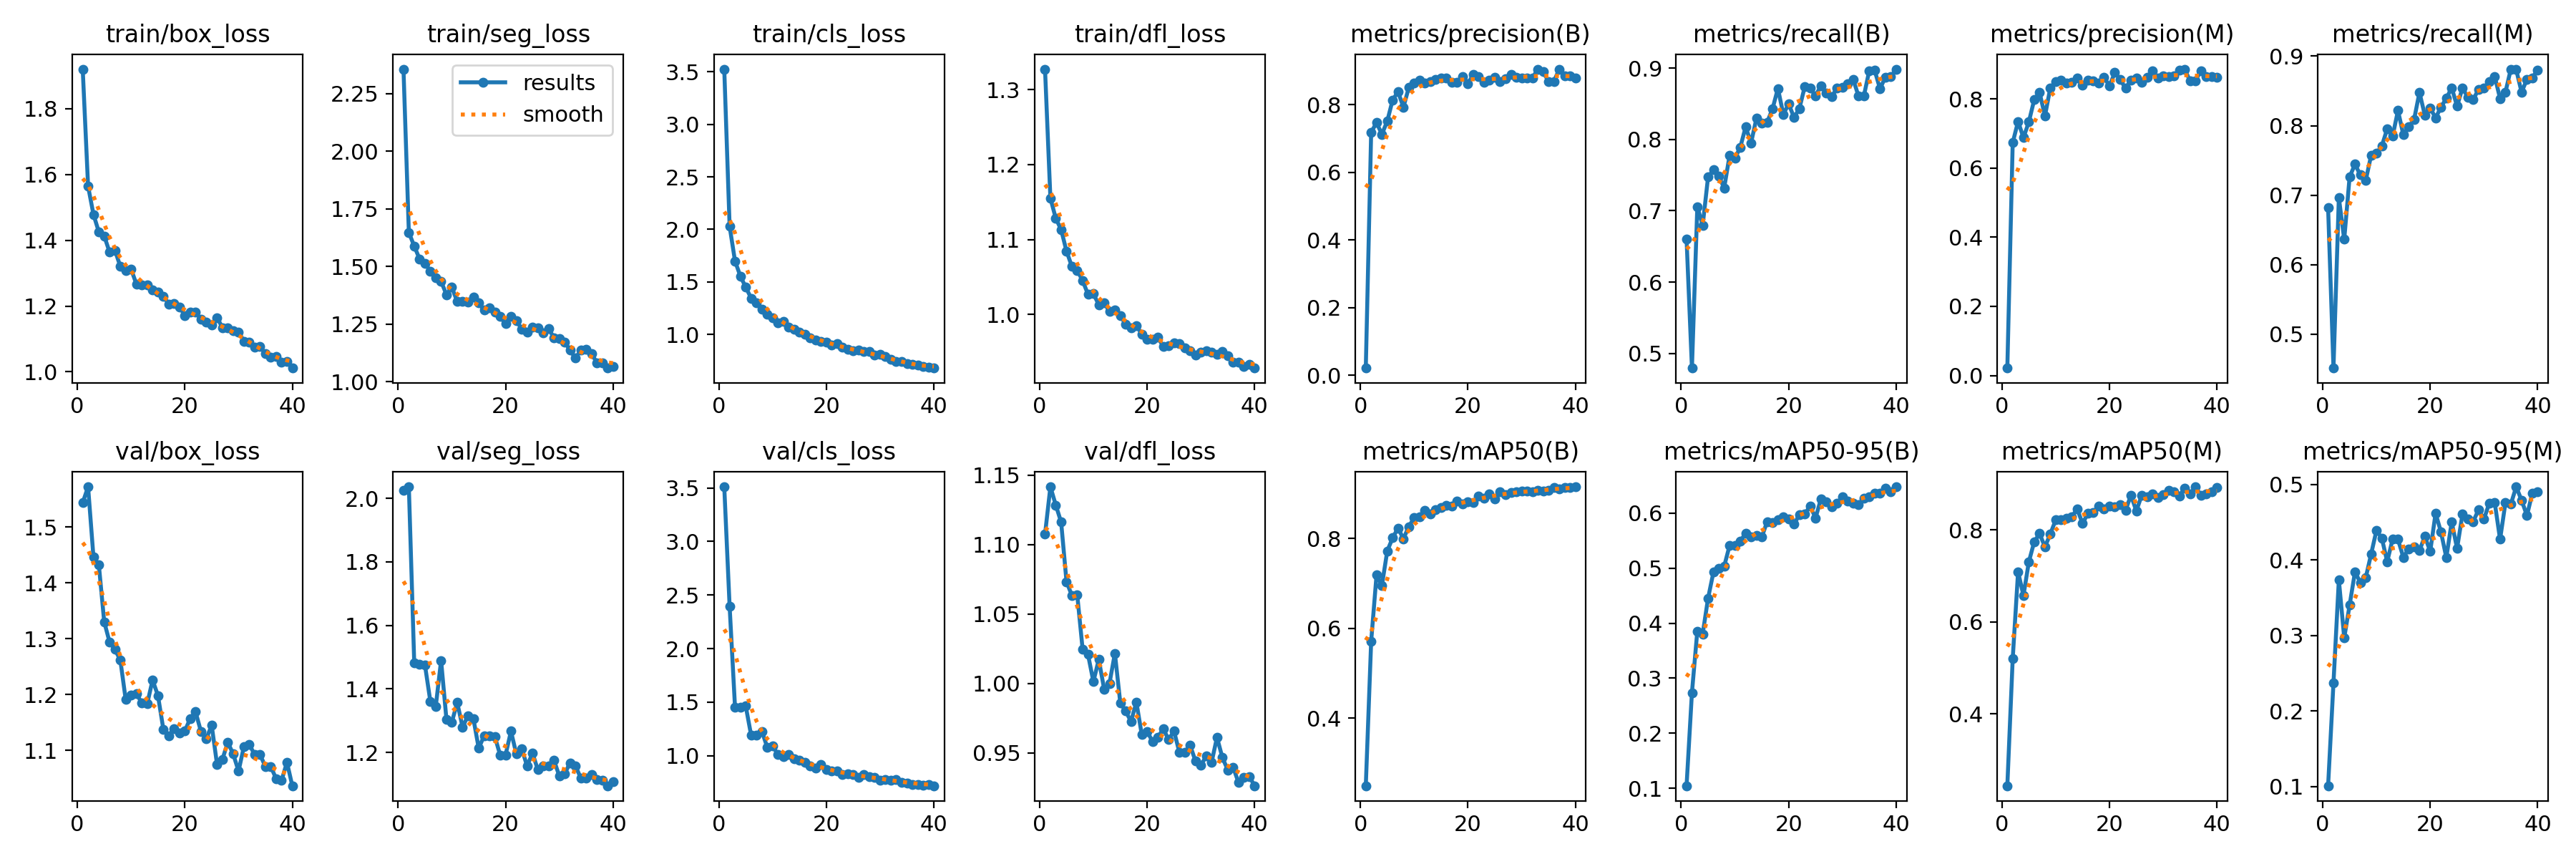

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/results.png', width=600)

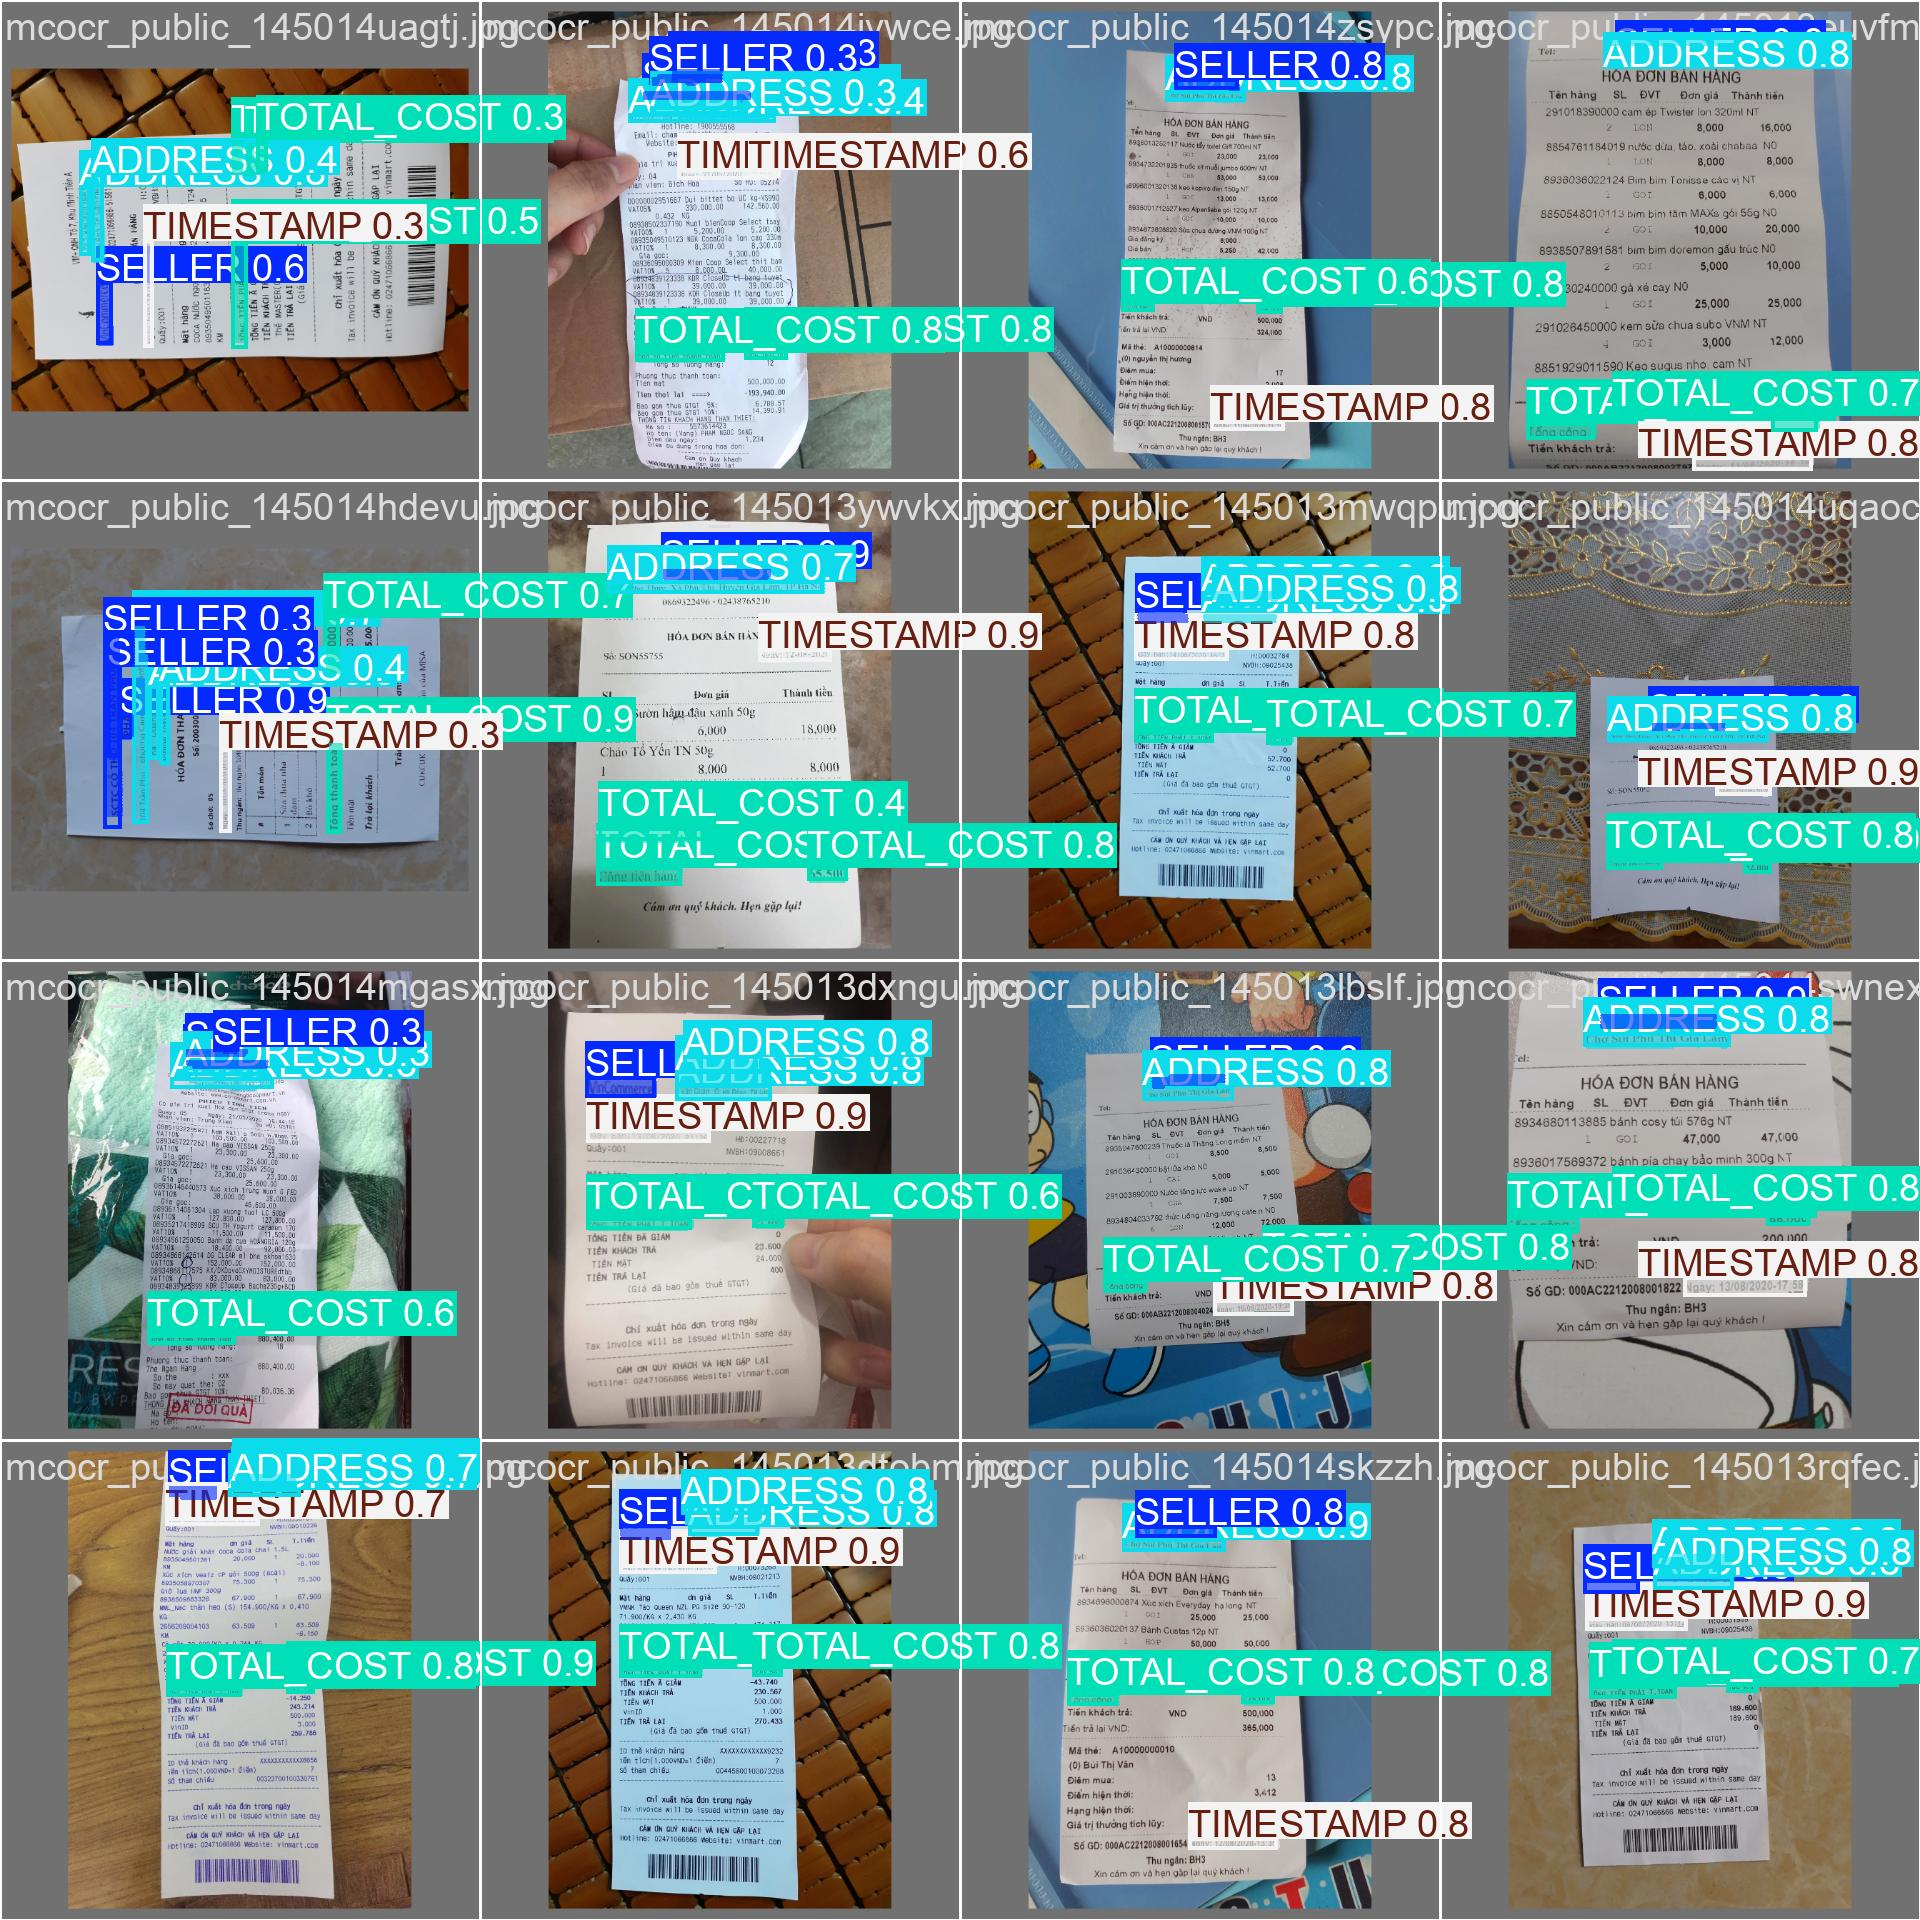

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [ ]:
!yolo task=segment mode=val model={HOME}/runs/segment/train/weights/best.pt data={HOME}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,348 parameters, 0 gradients, 10.2 GFLOPs
val: Scanning /content/dataset/val/labels.cache... 116 images, 0 backgrounds, 0 corrupt: 100% 116/116 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 8/8 [00:05<00:00,  1.58it/s]
                   all        116        678      0.879      0.899      0.916       0.65      0.856      0.876      0.881      0.472
                SELLER        105        116      0.869      0.922      0.933      0.671      0.861      0.914      0.909      0.488
               ADDRESS        108        207      0.885      0.931      0.934      0.673      0.862      0.906      0.897      0.501
             TIMESTAMP        106        119      0.868      0.882      0.918      0.664      0.843      0.856      0.882      0.458
           

In [ ]:
!yolo task=segment mode=val model={HOME}/runs/segment/train/weights/last.pt data={HOME}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,348 parameters, 0 gradients, 10.2 GFLOPs
val: Scanning /content/dataset/val/labels.cache... 116 images, 0 backgrounds, 0 corrupt: 100% 116/116 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 8/8 [00:04<00:00,  1.62it/s]
                   all        116        678      0.879      0.899      0.916       0.65      0.856      0.876      0.881      0.472
                SELLER        105        116      0.869      0.922      0.933      0.671      0.861      0.914      0.909      0.488
               ADDRESS        108        207      0.885      0.931      0.934      0.673      0.862      0.906      0.897      0.501
             TIMESTAMP        106        119      0.868      0.882      0.918      0.664      0.843      0.856      0.882      0.458
           

## Inference with custom model

In [ ]:
!yolo task=segment mode=predict model={HOME}/runs/segment/train/weights/best.pt conf=0.5 source={HOME}/dataset/val/images save=True

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n-seg summary (fused): 265 layers, 2,835,348 parameters, 0 gradients, 10.2 GFLOPs

image 1/116 /content/dataset/val/images/mcocr_public_145013aagqw.jpg: 640x480 1 SELLER, 2 ADDRESSs, 1 TIMESTAMP, 1 TOTAL_COST, 49.4ms
image 2/116 /content/dataset/val/images/mcocr_public_145013bsywa.jpg: 640x480 1 SELLER, 1 ADDRESS, 1 TIMESTAMP, 2 TOTAL_COSTs, 9.8ms
image 3/116 /content/dataset/val/images/mcocr_public_145013chgcz.jpg: 640x480 1 SELLER, 3 ADDRESSs, 1 TIMESTAMP, 2 TOTAL_COSTs, 9.1ms
image 4/116 /content/dataset/val/images/mcocr_public_145013cleap.jpg: 640x384 1 SELLER, 3 ADDRESSs, 1 TIMESTAMP, 2 TOTAL_COSTs, 49.8ms
image 5/116 /content/dataset/val/images/mcocr_public_145013clltn.jpg: 640x384 1 SELLER, 1 ADDRESS, 2 TOTAL_COSTs, 16.5ms
image 6/116 /content/dataset/val/images/mcocr_public_145013doybn.jpg: 640x384 1 SELLER, 1 ADDRESS, 1 TIMESTAMP, 2 TOTAL_COSTs, 9.1ms
image 7/116 /content/dataset/val/images

**NOTE:** Let's take a look at few results.

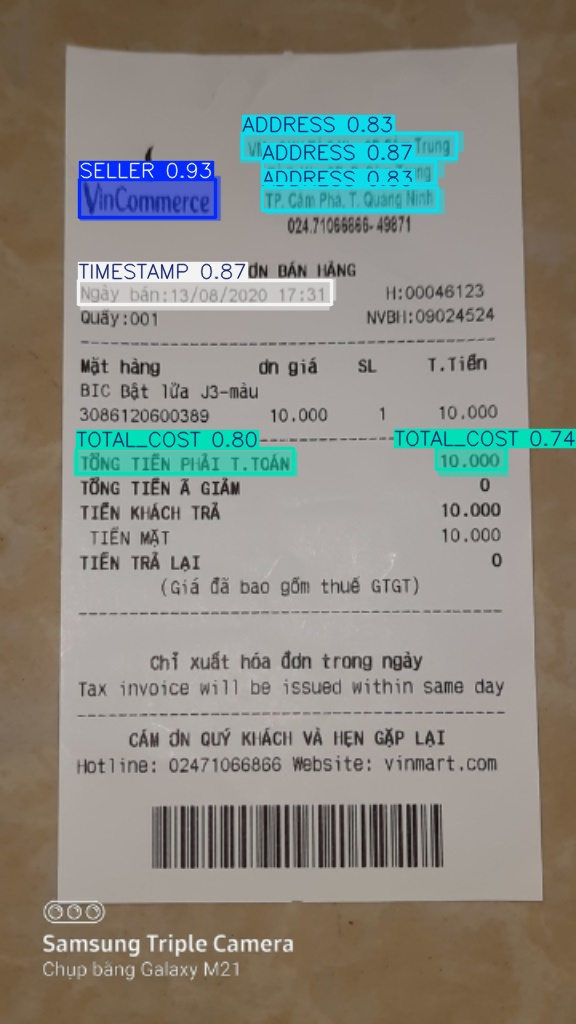

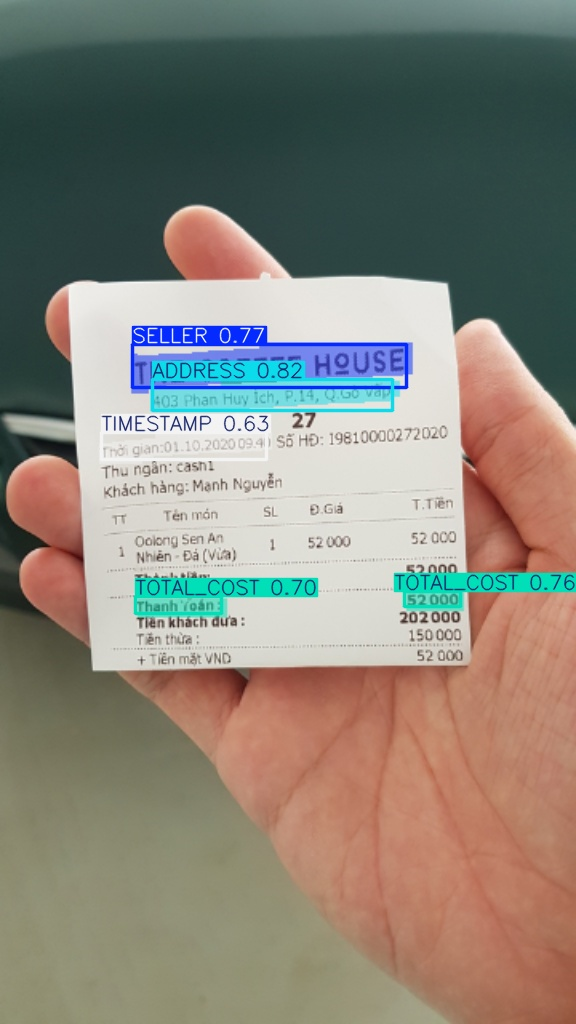

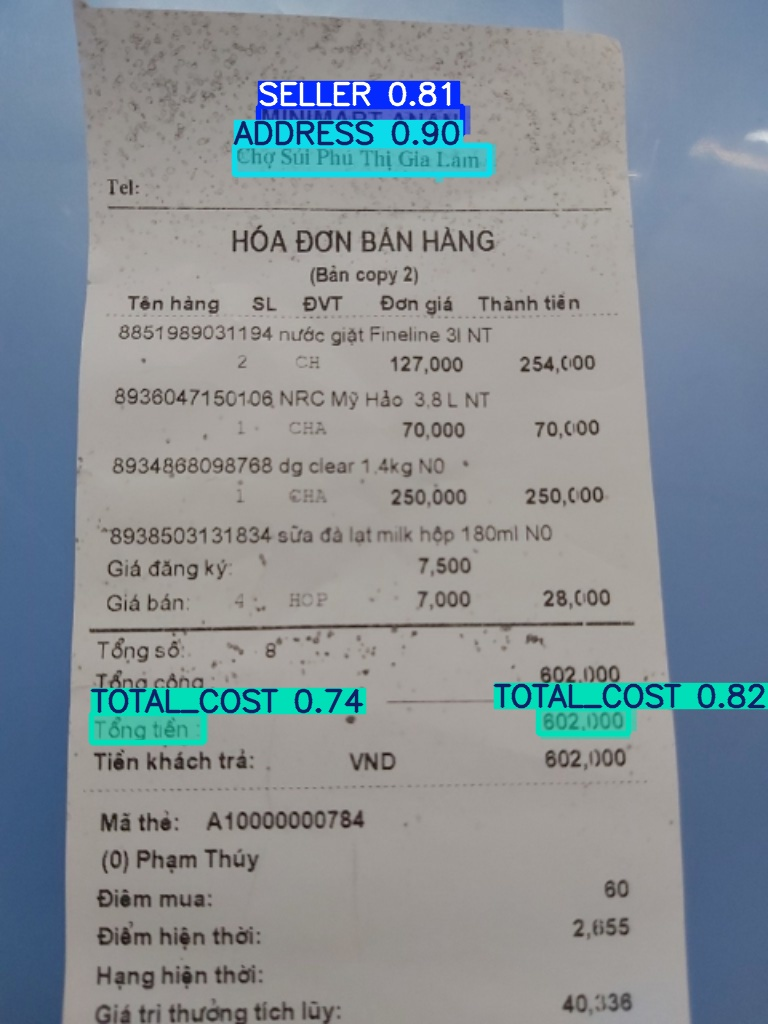

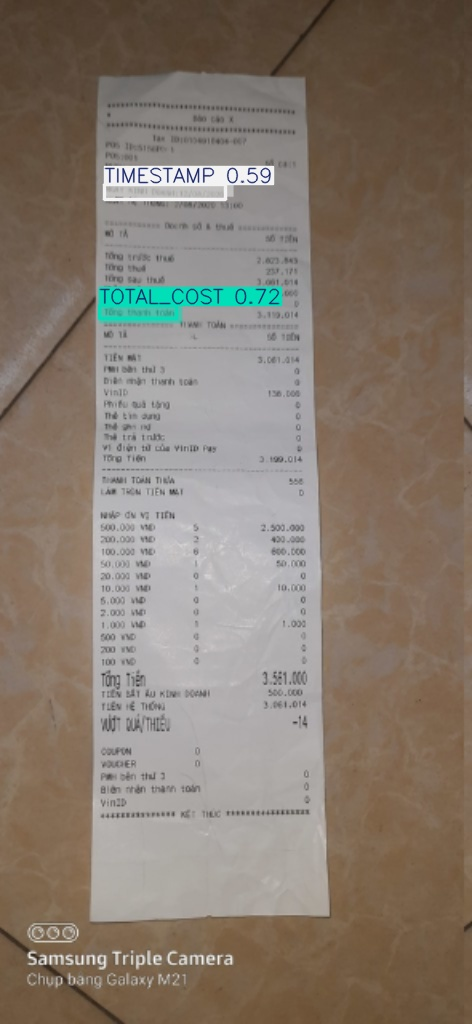

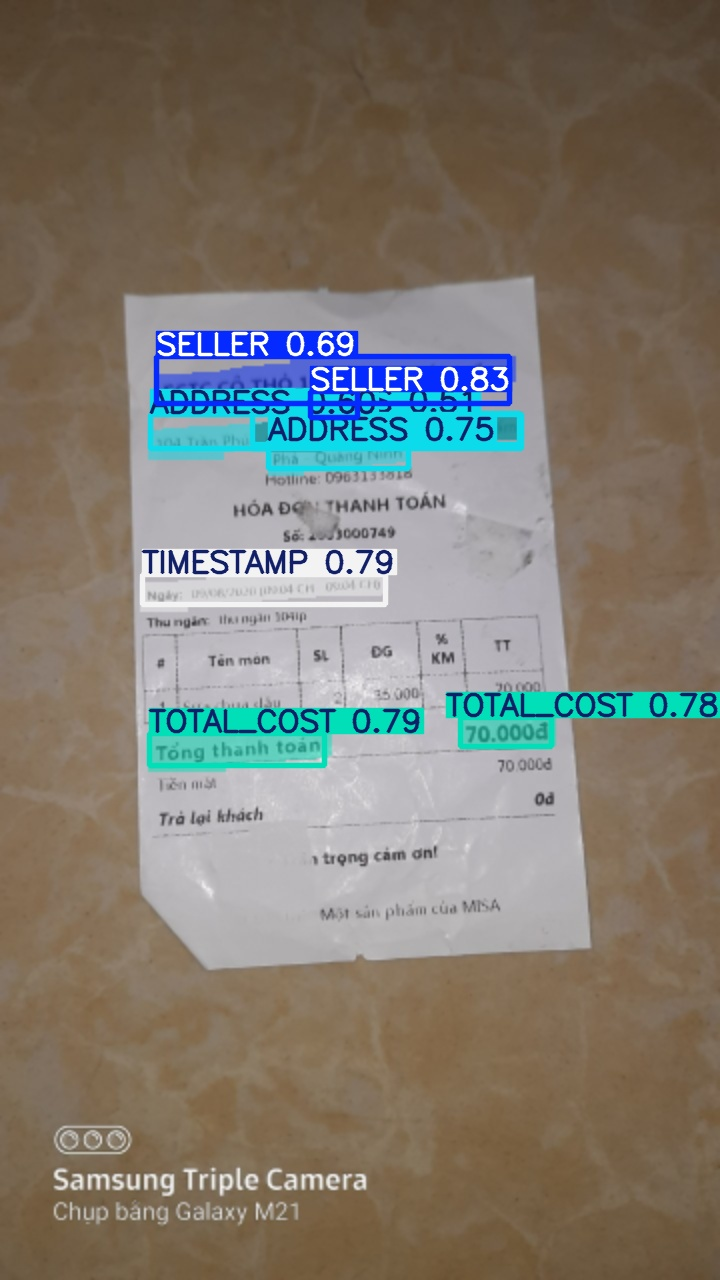

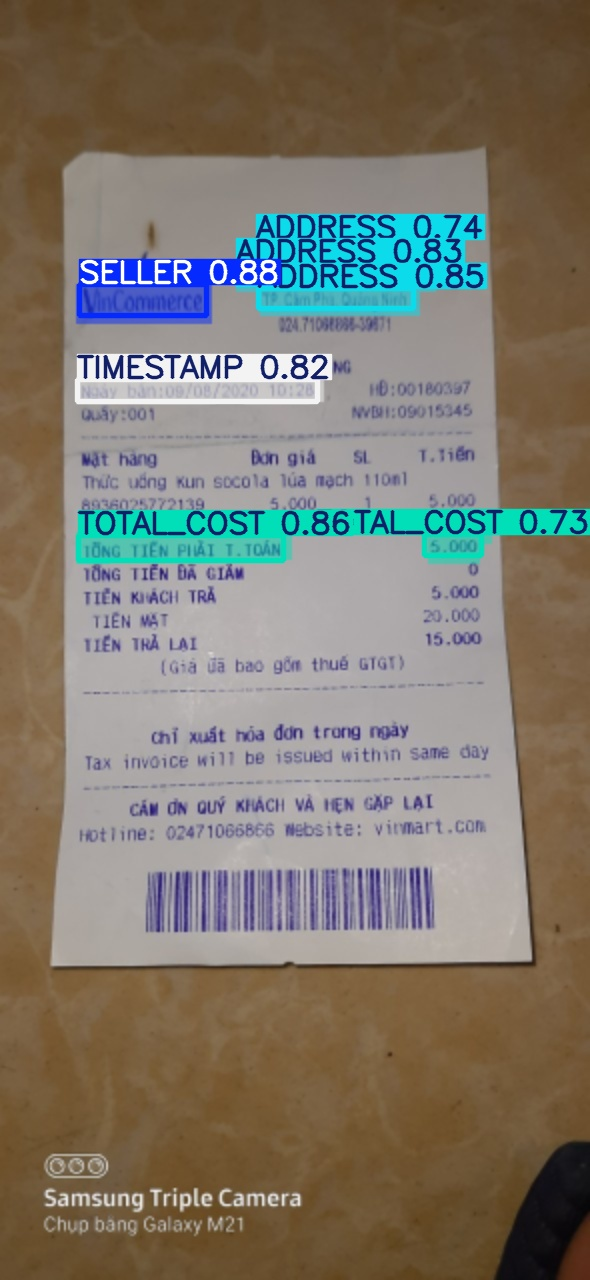

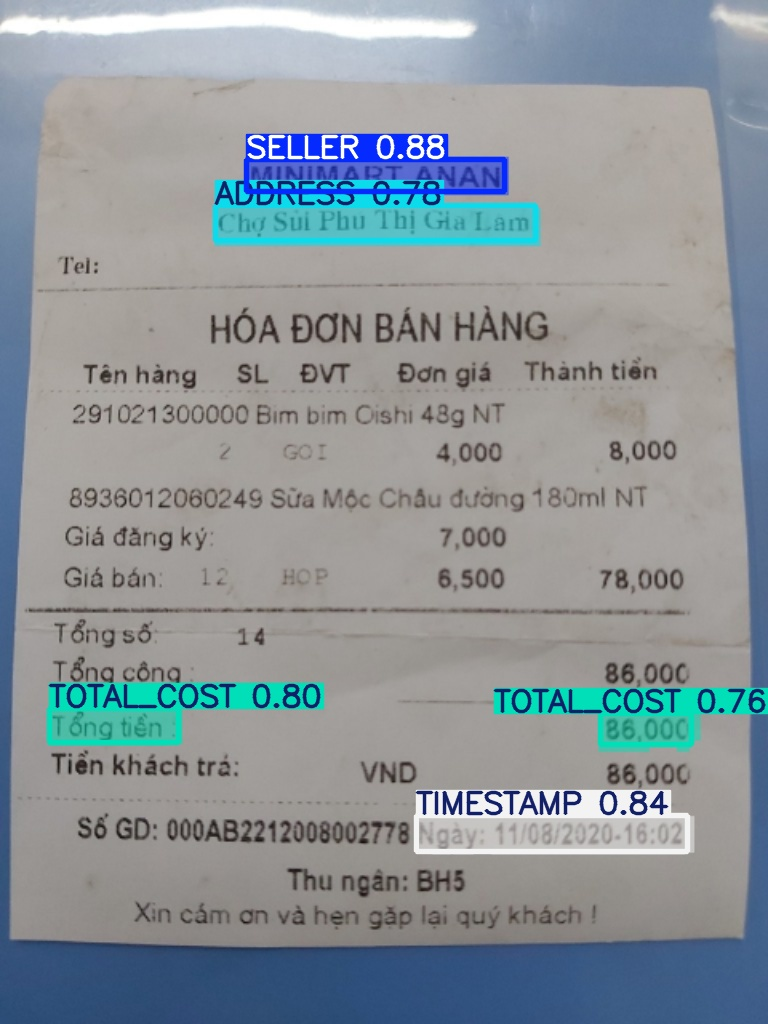

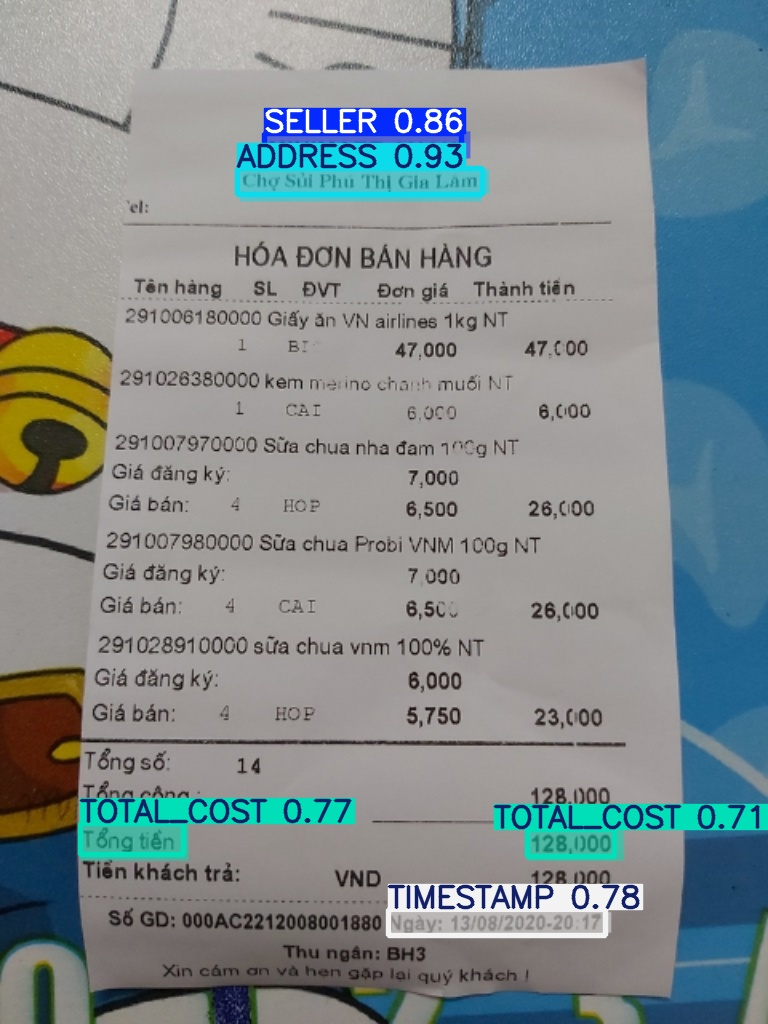

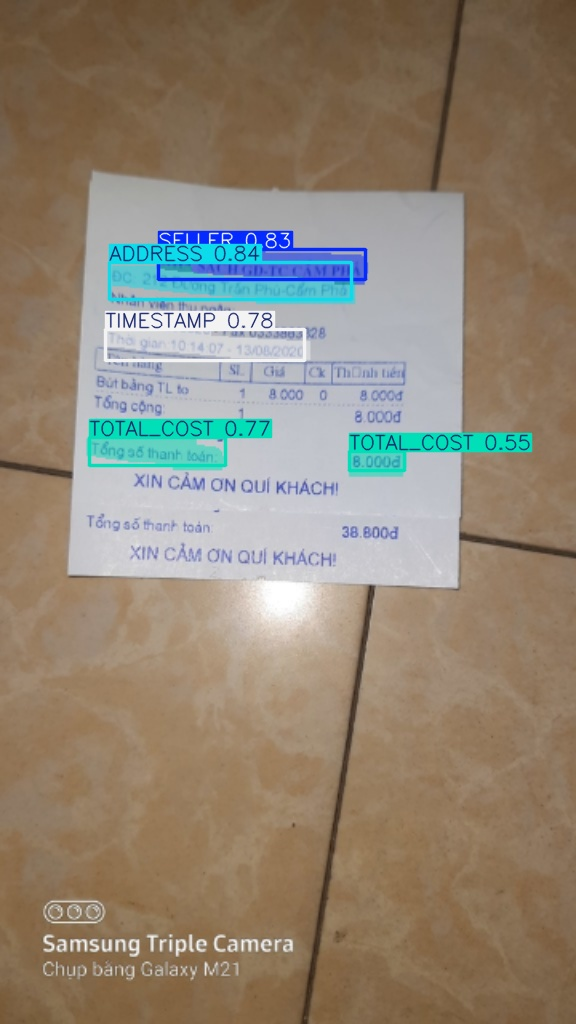

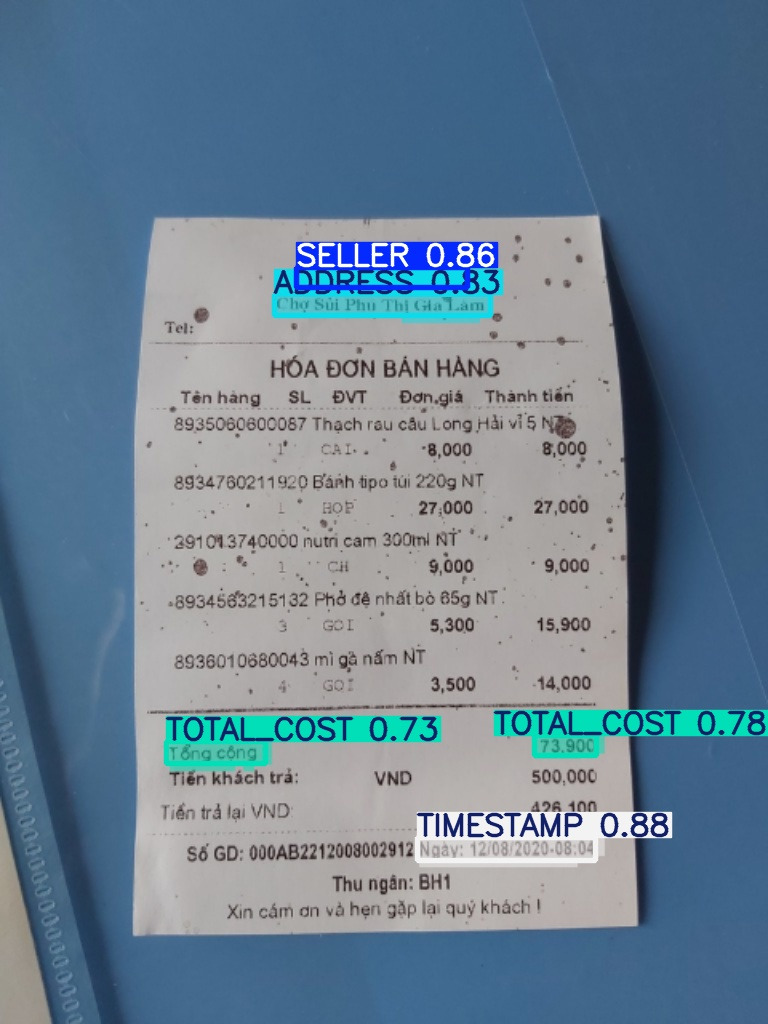

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/segment/predict/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:10]:
    display(IPyImage(filename=img, width=600))
    print("\n")